In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint
from config import root_dir
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tcav.utils import writeTensorsName
import cv2
from PIL import Image
import numpy as np
import os

In [2]:
batch_size = 64
epochs = 10
num_classes = 10
type = 'number' #color or number
train_path = root_dir + 'tcav/dataset/for_train/Colored_mnist/' + type + '/train'
test_path = root_dir + 'tcav/dataset/for_train/Colored_mnist/' + type + '/test'
save_path = root_dir + 'tcav/frozen_models/'
dataset_path = root_dir + 'tcav/dataset/'
save_name = 'mnist_' + type + '_2layers_cnn'
model_name = '2layers_cnn'
dataset_name = 'colored_mnist_' + type
WIDTH = 200
HEIGHT = 200
input_shape = (WIDTH,HEIGHT,3)

In [3]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, name='conv1'))
model.add(Conv2D(32, (3, 3), activation='relu', name='conv2'))
# model.add(Conv2D(32, (3, 3), activation='relu', name='conv3'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu', name='conv4'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 198, 198, 16)      448       
_________________________________________________________________
conv2 (Conv2D)               (None, 196, 196, 32)      4640      
_________________________________________________________________
flatten (Flatten)            (None, 1229312)           0         
_________________________________________________________________
dense (Dense)                (None, 10)                12293130  
Total params: 12,298,218
Trainable params: 12,298,218
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(loss='categorical_crossentropy',
               optimizer='sgd',
               metrics=['accuracy'])


# train_datagen = ImageDataGenerator(
#      rescale=1.0 / 255,
#     shear_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True)

train_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical')
    

Found 57480 images belonging to 10 classes.
Found 9980 images belonging to 10 classes.


In [5]:
os.makedirs('models', exist_ok=True)
os.makedirs('models/' + dataset_name, exist_ok=True)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join('models/' + dataset_name, model_name+'_{epoch:02d}_{val_acc:.2f}.ckpt'),
    monitor='val_acc',
    save_weights_only = True,
    verbose=1)

In [9]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[model_checkpoint]
    )

Epoch 1/10
899/899 [==============================] - 910s 1s/step - loss: 0.4195 - acc: 0.8818 - val_loss: 0.3201 - val_acc: 0.9096
Epoch 2/10
899/899 [==============================] - 731s 813ms/step - loss: 0.3022 - acc: 0.9128 - val_loss: 0.3179 - val_acc: 0.8993
Epoch 3/10
899/899 [==============================] - 702s 781ms/step - loss: 0.2725 - acc: 0.9224 - val_loss: 0.2647 - val_acc: 0.9237
Epoch 4/10
396/899 [============>.................] - ETA: 6:21 - loss: 0.2476 - acc: 0.9302

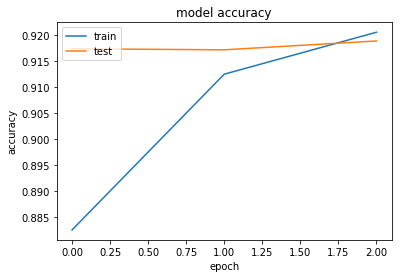

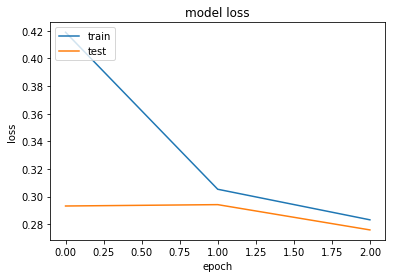

In [14]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
print('epoch {}'.format(epochs))
print('image size {}'.format(WIDTH,HEIGHT))
print('class {}'.format(num_classes))
print('num train data {}'.format(11229))
print('num test data {}'.format(2932))
print('batch_size {}'.format(batch_size))
print('train acc {}'.format(history.history['acc'][-1]))
print('test acc {}'.format(history.history['val_acc'][-1]))

epoch 3
image size 200
class 10
num train data 11229
num test data 2932
batch_size 64
train acc 0.9206158518791199
test acc 0.9189378619194031


In [16]:
# outputのノード名が必要なのでprintして確認する
print(model.output.op.name)
output_node_name = model.output.op.name
#ファイル名を.ckptとしてモデルを保存
saver = tf.train.Saver()
saver.save(K.get_session(), 'frozen_model.ckpt')

dense/Softmax


'frozen_model.ckpt'

In [17]:
output_path = save_path + save_name + '.pb'
os.system('python tensorflow/tensorflow/python/tools/freeze_graph.py --input_meta_graph=frozen_model.ckpt.meta --input_checkpoint=frozen_model.ckpt --output_graph={0}  --output_node_names={1} --input_binary=true'.format(output_path,output_node_name))
os.system('rm -rf frozen_model.ckpt*')
os.system('rm checkpoint')

0

In [18]:
output_name_path = output_path[:-3] + '_name'
if os.path.exists(output_name_path) == False:
  writeTensorsName(output_path,output_name_path)

In [19]:
# label保存

with open(dataset_path + dataset_name, mode='w') as f:
  for name in train_generator.class_indices.keys():
    f.write(name + '\n')

In [20]:
output_summary_path = output_path[:-3] + '_summary'
with open(output_summary_path, "w") as fp:
    model.summary(print_fn=lambda x: fp.write(x + "\r\n"))